## About
This program predicts the future prices of a stock using ARIMA (Auto Regressive Integrated Moving Average).

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
%matplotlib inline

## Download the historical data

#### Set start date and end date

In [2]:
end_date = '2021-05-22'
end_date = datetime.strptime(end_date, '%Y-%m-%d')
start_date = end_date - relativedelta(years=1)

#### Fetch data from Yahoo Finance

In [3]:
ticker = 'MSFT'
df = pd.DataFrame()
df[ticker] = yf.download(ticker, start=start_date, end=end_date)['Close']

[*********************100%***********************]  1 of 1 completed


#### Plot the source data

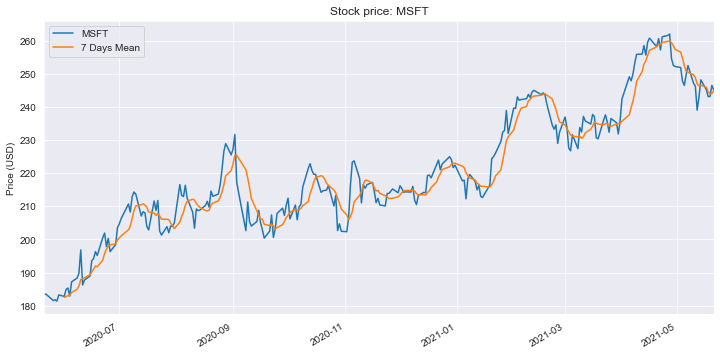

In [4]:
df['7 Days Mean'] = df.rolling(window=7).mean()
title='Stock price: ' + ticker
ylabel='Price (USD)'
xlabel=''
ax = df.plot(figsize=(12, 6), title=title)
ax.autoscale(tight=True, axis='x')
ax.set(xlabel='', ylabel=ylabel)
df.drop('7 Days Mean', inplace=True, axis=1)

## Optional: Run ETS (Error-Trend-Seasonality) decomposition

In [5]:
trading_days_year = 252
trading_days_quarter = 63
trading_days_month = 21
result = seasonal_decompose(df[ticker], model='add', freq=trading_days_month)

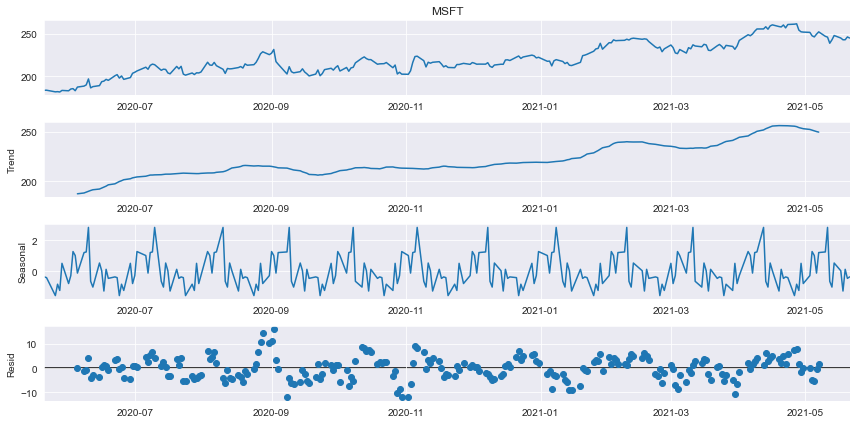

In [6]:
plt.rc("figure", figsize=(12,6))
result.plot();

## Optional: Stationarity

#### Run the augmented Dickey-Fuller Test to confirm stationarity

In [7]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df[ticker], ticker+' original data')

Augmented Dickey-Fuller Test: MSFT original data
ADF test statistic       -1.795321
p-value                   0.382787
# lags used               1.000000
# observations          251.000000
critical value (1%)      -3.456674
critical value (5%)      -2.873125
critical value (10%)     -2.572944
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


#### Run the augmented Dickey-Fuller Test on the first order difference

In [9]:
df['d1'] = diff(df[ticker], k_diff=1)

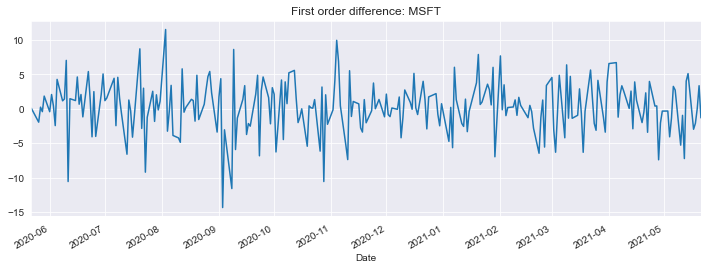

In [10]:
title = 'First order difference: '+ ticker
df['d1'].plot(figsize=(12,4), title=title).autoscale(tight=True, axis='x')

In [11]:
adf_test(df['d1'],ticker + ' first order difference')

Augmented Dickey-Fuller Test: MSFT first order difference
ADF test statistic     -1.803846e+01
p-value                 2.662450e-30
# lags used             0.000000e+00
# observations          2.510000e+02
critical value (1%)    -3.456674e+00
critical value (5%)    -2.873125e+00
critical value (10%)   -2.572944e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Optional: Run the ACF and PACF plots
<a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting notes</a>:<br>
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
An AR signature corresponds to a PACF plot displaying a sharp cut-off and a more slowly decaying ACF. <br>
An MA signature corresponds to an ACF plot displaying a sharp cut-off and a PACF plot that decays more slowly. <br> 

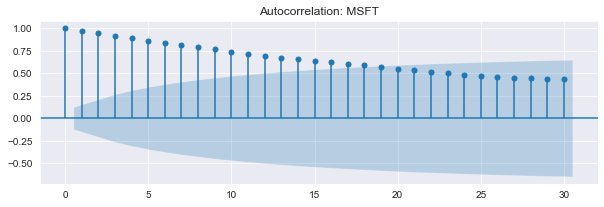

In [12]:
title = 'Autocorrelation: ' + ticker
lags = 30
fig, ax = plt.subplots(figsize=(10,3))
plot_acf(df[ticker], title=title, lags=lags, ax=ax);

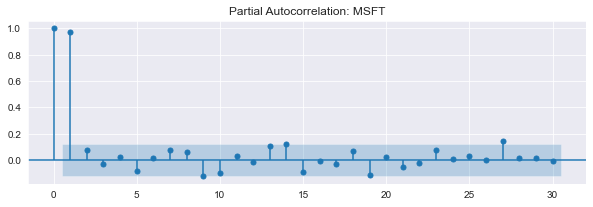

In [13]:
title = 'Partial Autocorrelation: ' + ticker
lags = 30
fig, ax = plt.subplots(figsize=(10,3))
plot_pacf(df[ticker], title=title, lags=lags, ax=ax);

## Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to obtain the best combination.

In [14]:
stepwise_fit = auto_arima(df[ticker], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=1,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1392.318, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1389.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1389.899, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1391.362, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1391.809, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1391.518, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1393.040, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1389.185, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1391.148, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1390.733, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1389.303, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1392.344, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.537 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  253
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -692.592
Date:                Tue, 24 Aug 2021   AIC                           1389.185
Time:                        14:18:10   BIC                           1396.243
Sample:                             0   HQIC                          1392.025
                                - 253                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1280      0.057     -2.252      0.024      -0.239      -0.017
sigma2        14.2794      1.066     13.391      0.000      12.189      16.369
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.68
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.35
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
auto_order = stepwise_fit.get_params()['order']
print('ARIMA order = ',auto_order)

ARIMA order =  (1, 1, 0)


## Create the ARIMA(p,d,q) model

#### Split the data into train/test sets


In [16]:
n = int(len(df) * 0.8)
train = df[ticker][:n]
test = df[ticker][n:]
print(len(train))
print(len(test))

202
51


#### Fit an ARIMA(p,d,q) Model


In [17]:
model = ARIMA(train,order=auto_order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.MSFT   No. Observations:                  201
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -555.932
Method:                       css-mle   S.D. of innovations              3.845
Date:                Tue, 24 Aug 2021   AIC                           1117.865
Time:                        14:18:10   BIC                           1127.775
Sample:                             1   HQIC                          1121.875
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2450      0.234      1.048      0.295      -0.213       0.703
ar.L1.D.MSFT    -0.1613      0.069     -2.322      0.020      -0.297      -0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.2003           +0.0000j            6.2003            0.5000
-----------------------------------------------------------------------------
"""

#### Obtain predicted values

In [18]:
start=len(train)
end=len(train)+len(test)-1
# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions, se, conf = results.forecast(steps=len(test), alpha=0.05)

In [19]:
# set index
model_name = 'ARIMA Prediction'
predictions = pd.Series(data=predictions, index=test.index).rename(model_name)
lower = pd.Series(conf[:, 0], index=test.index)
upper = pd.Series(conf[:, 1], index=test.index)

#### Evaluate the Model

In [20]:
error = mean_squared_error(test, predictions)
print(f'{model_name} MSE Error: {error:11.10}')
print(f'{model_name} RMSE Error: {np.sqrt(error):11.10}')

ARIMA Prediction MSE Error: 130.7864156
ARIMA Prediction RMSE Error: 11.43618886


#### Plot predictions against expected values


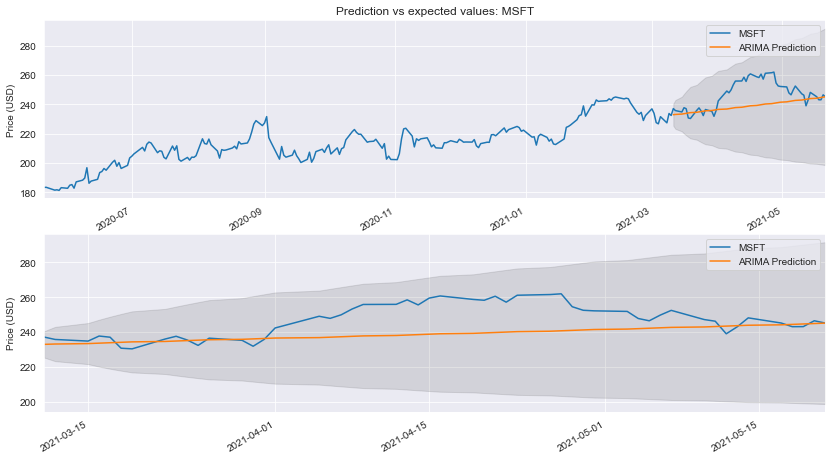

In [21]:
title='Prediction vs expected values: ' + ticker
ylabel='Price (USD)'
xlabel=''
fig, ax = plt.subplots(2, 1)

df[ticker].plot(legend=True,figsize=(14,8),title=title, ax=ax[0])
predictions.plot(legend=True, ax=ax[0])

test.plot(legend=True, ax=ax[1])
predictions.plot(legend=True, ax=ax[1])
for i in range(2):
    ax[i].autoscale(tight=True,axis='x')
    ax[i].set(xlabel=xlabel, ylabel=ylabel)
    ax[i].fill_between(lower.index, lower, upper, color="k", alpha=0.1);

## Forecast future data

#### Retrain the model on the full data, and forecast the future

In [22]:
model = ARIMA(df[ticker],order=auto_order)
results = model.fit()
fcast_days = len(test)
fcast, se, conf = results.forecast(steps=fcast_days, alpha=0.05)

In [23]:
# set index
model_name = 'ARIMA Forecast'
# business days
idx = pd.date_range(start=df.index[-1], periods=fcast_days+1, freq='B')
idx = idx[1:]
fcast = pd.Series(data=fcast, index=idx).rename(model_name)
lower = pd.Series(conf[:, 0], index=idx)
upper = pd.Series(conf[:, 1], index=idx)

#### Plot forecast data

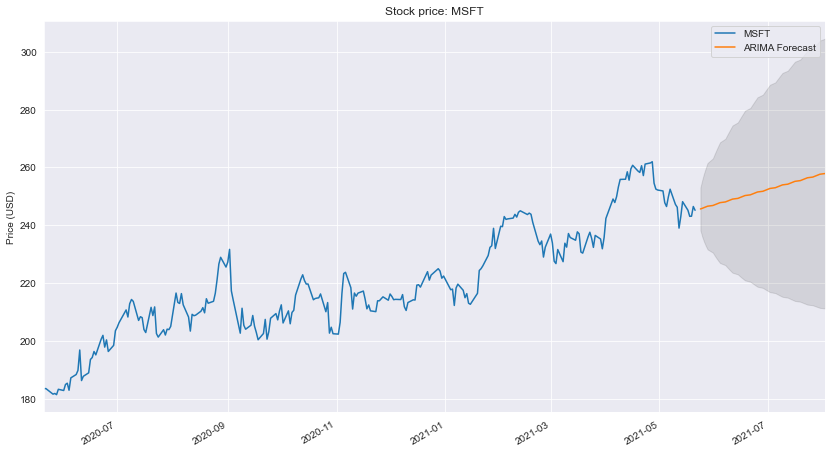

In [24]:
title='Stock price: ' + ticker
ylabel='Price (USD)'
xlabel=''

ax = df[ticker].plot(legend=True,figsize=(14,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
fcast.plot(legend=True)
ax.fill_between(lower.index, lower, upper, color="k", alpha=0.1);